# COMPARACIÓN DEL Nº DE COPIA EN SECUENCIAS COMPARTIDAS
Frente a la pregunta _¿dónde hay mayor nº de copias de ARG/MGE?_ el poder responder ha sido siempre controvertido, puesto que el hecho de que haya infinidad de 0s dificulta muchísimo el tomar todos los datos en conjunto a la par que la contra, el centrarse sólo en los genes que han amplificado, dificulta mucho el poder responder a la pregunta y quita muchísimas réplicas, tanto que empieza a haber problemas de poder estadístico.

Sin embargo, creo que la solución pasa por asumir esas dos circunstancias y hacerlas parte de nuestra respuesta: _¿dónde hay mayor nº de copias de ARG/MGE? **Depende: a nivel general, en los plásticos por su mayor diversidad, pero a nivel de genes/familias compartidas, la respuesta depende del ambiente, aunque hay casos en los que nos falta poder estadístico para poder responder con seguridad**_

Dicho eso, al meollo.

Se me ocurre responder de dos maneras a la pregunta.

1.  **Ver cuáles son los ARG comunes, computar la suma de NCN para ellos en cada muestra, dividirlo por el nº de secuencias comunes para ese caso y comparar**
2. Por si hiciera falta, también se puede respaldar con la misma pregunta pero usando _todas_ las secuencias. Eso respondería en general.

Ojo, voy a separar desde el principio ARGs y MGEs. No me interesa comparar entre ellos en ningún caso y tenerlos juntos supone mezclar dos datasets que pueden meter mucho ruido sin causa justificada.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import scikit_posthocs as sp
import matplotlib
import warnings
warnings.filterwarnings("ignore")

## EN GENERAL POR COMPLETO

In [2]:
all_data = pd.read_csv("../data/resistome_data/clean_data/ab_data_all_fixed.csv", index_col = 0)
all_data.dropna(inplace = True)
all_data = all_data[(all_data["antib"] != "16S")]
all_data = all_data[["Assay", "antib", "sample", "place", "type_f", "type_g", "or_seq", "rel_ab"]] #place viene a ser la estrella del show
all_data = all_data.loc[~all_data["place"].isin([0])]
all_data.loc[all_data["sample"] == 13, "rel_ab"] = all_data.loc[all_data["sample"] == 13]["rel_ab"] / 3
all_data.loc[all_data["sample"] == 14, "rel_ab"] = all_data.loc[all_data["sample"] == 14]["rel_ab"] / 3
all_data = all_data[(all_data.Assay != "aadA7") & (all_data.sample != 5)] #esto también es tremendamente importante
common_amps = all_data[["Assay", "place", "type_g"]].groupby(["place", "Assay"])["type_g"].unique()
common_amps = common_amps.reset_index()
common_amps["type_g"] = common_amps["type_g"].astype("str") #hacky as shit
common_amps = common_amps.loc[(common_amps["type_g"] == "['plastic' 'control']") | (common_amps["type_g"] == "['control' 'plastic']")]

fixed_ardley_data = all_data.loc[all_data["place"] == "ardley"] 
fixed_ardley_data = fixed_ardley_data.loc[fixed_ardley_data["Assay"].isin(list(common_amps.loc[common_amps["place"] == "ardley"]["Assay"].unique()))]
fixed_uru_data = all_data.loc[all_data["place"] == "uru"]
fixed_uru_data = fixed_uru_data.loc[fixed_uru_data["Assay"].isin(list(common_amps.loc[common_amps["place"] == "uru"]["Assay"].unique()))]
fixed_ion_data = all_data.loc[all_data["place"] == "ion"]
fixed_ion_data = fixed_ion_data.loc[fixed_ion_data["Assay"].isin(list(common_amps.loc[common_amps["place"] == "ion"]["Assay"].unique()))]

fixed_all = pd.concat([fixed_ardley_data, fixed_uru_data, fixed_ion_data])
fixed_all.loc[(fixed_all["place"] == "ion") | (fixed_all["place"] == "uru"), "place"] = "lake"

In [3]:
# He aquí lo interesante: sacar el nº de ocurrencias por sitio
lake_arg_counts = len(fixed_all.loc[(fixed_all["place"] == "lake") & (fixed_all["or_seq"] == "arg")]["Assay"].unique())
ardley_arg_counts = len(fixed_all.loc[(fixed_all["place"] == "ardley") & (fixed_all["or_seq"] == "arg")]["Assay"].unique())
lake_mge_counts = len(fixed_all.loc[(fixed_all["place"] == "lake") & (fixed_all["or_seq"] == "mge")]["Assay"].unique())
ardley_mge_counts = len(fixed_all.loc[(fixed_all["place"] == "ardley") & (fixed_all["or_seq"] == "mge")]["Assay"].unique())
print("There's: ", lake_arg_counts, " ARGs shared in lakes and ", ardley_arg_counts, " ARGs shared in Ardley")
print("There's: ", lake_mge_counts, " MGEs shared in lakes and ", ardley_mge_counts, " MGEs shared in Ardley")

There's:  14  ARGs shared in lakes and  191  ARGs shared in Ardley
There's:  5  MGEs shared in lakes and  43  MGEs shared in Ardley


In [4]:
sp_grouped = fixed_all.groupby(["sample", "or_seq", "place", "type_g"]) #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples = sp_grouped["rel_ab"].sum() # y calcula la suma del nº de copias de todos los integrantes
summed_samples = summed_samples.reset_index() #aquí paso a df para facilitar el resto de pasos

#He aquí lo nuevo
summed_samples.loc[(summed_samples["place"] == "lake") & (summed_samples["or_seq"] == "arg"), "rel_ab"] = summed_samples.loc[(summed_samples["place"] == "lake") & (summed_samples["or_seq"] == "arg")]["rel_ab"] / lake_arg_counts
summed_samples.loc[(summed_samples["place"] == "ardley") & (summed_samples["or_seq"] == "arg"), "rel_ab"] = summed_samples.loc[(summed_samples["place"] == "ardley") & (summed_samples["or_seq"] == "arg")]["rel_ab"] / ardley_arg_counts
summed_samples.loc[(summed_samples["place"] == "lake") & (summed_samples["or_seq"] == "mge"), "rel_ab"] = summed_samples.loc[(summed_samples["place"] == "lake") & (summed_samples["or_seq"] == "mge")]["rel_ab"] / lake_mge_counts
summed_samples.loc[(summed_samples["place"] == "ardley") & (summed_samples["or_seq"] == "mge"), "rel_ab"] = summed_samples.loc[(summed_samples["place"] == "ardley") & (summed_samples["or_seq"] == "mge")]["rel_ab"] / ardley_mge_counts

summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
summed_samples.tail()

,sample,or_seq,place,type_g,rel_ab,n_log2
49,25.0,mge,ardley,plastic,0.185274,-2.432269
50,26.0,arg,ardley,plastic,0.039254,-4.671000
51,26.0,mge,ardley,plastic,0.147078,-2.765350
52,27.0,arg,ardley,plastic,0.057860,-4.111301
53,27.0,mge,ardley,plastic,0.183446,-2.446569


Aquí separaro entre ARG y MGE porque, como he comentado antes, no tiene sentido arrastrar ambos datos juntos cuando nunca voy a compararlos entre sí, estaría mezclando dos datasets por amor al arte

In [5]:
# Estas dos líneas siguientes son útiles para luego, pero como separo aquí, las meto antes de ser inmediatamente necesarias
summed_samples["hacky"] = summed_samples["place"] + " " + summed_samples["type_g"]
summed_samples.sort_values(by = "hacky", inplace = True)

summed_arg = summed_samples[(summed_samples.or_seq == "arg")]
summed_mge = summed_samples[(summed_samples.or_seq == "mge")]

summed_mge.head()

,sample,or_seq,place,type_g,rel_ab,n_log2,hacky
37,19.0,mge,ardley,control,0.068263,-3.872760,ardley control
39,20.0,mge,ardley,control,0.095846,-3.383144,ardley control
41,21.0,mge,ardley,control,0.043573,-4.520435,ardley control
53,27.0,mge,ardley,plastic,0.183446,-2.446569,ardley plastic
43,22.0,mge,ardley,plastic,0.207896,-2.266068,ardley plastic


In [6]:
def statistic_mean(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)
def get_difs(groupby_data, var = "rel_ab", detailed = False, alternative = "two-sided", significant = True, grouping_var = "type_g"):
    """
    A highly hardcoded function that I'm defining only because it will make the rest of the notebook cleaner. Designed to take a multi-indexed groupby object
    and perform some basic analysys on it: normality, homocedasticity and the corresponding test of means' difference. It probably incurs in Type I error, as it compares multiples
    pairs of control-sample samples (they are NOT paired samples, mind you)
    
    - groupby_data: the groupby object that contains the data to analyze. As it is programmed, it MUST contain a column with a descriptive, binary value: control and study samples
    - var: name of the column whose values we want to compare
    - detailed: change it to True to get a detailed printing of all the tests being conducted
    - alternative: which altenative hypothesis to feed to the paired tests. I0m running scipy tests, so it works with the same values (less, two-sided, greater)
    - significant: if True, keep just those with pval < 0.05; if False, keep everything
    """
    result_dict = {}
    for name, group in groupby_data:
        name = str(name).upper()
        pl_data = group.loc[group[grouping_var] == "plastic"][var]
        con_data = group.loc[group[grouping_var] == "control"][var]
        
        # Tests de normalidad
        norm_plas = stats.shapiro(pl_data)
        norm_con = stats.shapiro(con_data)
        
        # Tests de homocedasticidad
        if (norm_plas[1] > 0.05) and (norm_con[1] > 0.05):
            norm = True
            homo = stats.bartlett(pl_data, con_data)
        else: 
            norm = False
            homo = stats.levene(pl_data, con_data)
            
        # Test de igualdad de distribuciones
        if (homo[1] > 0.05) and (norm == True): 
            result = stats.ttest_ind(a = pl_data, b = con_data, alternative = alternative)
        elif (homo[1] > 0.05): #homocedásticos no normales
            result = stats.mannwhitneyu(x = pl_data, y = con_data, alternative = alternative)
        elif (homo[1] < 0.05) and (norm == True): #normales no homocedásticos
            result = stats.ttest_ind(a = pl_data, b = con_data, alternative = alternative, equal_var = False)
            result = ("Welch!", result[1], result[0])
        else: #todo mal, permuta
            result = stats.permutation_test(data = (pl_data, con_data), statistic =  statistic_mean, 
                                            vectorized = True, n_resamples = 20000,
                                            alternative = alternative, permutation_type = "independent")
            result = ("Permutation", result.pvalue, result.statistic) #ugly hack!
        if significant == True:
            if result[1] < 0.05: result_dict[name] = result
        else: 
            result_dict[name] = result
            
            
            
        if detailed == True:
            print("##########", name, "#########")
            print("### PLASTIC ###")
            print(norm_plas)
            print("### CONTROL ###")
            print(norm_con)
            print("### BOTH ###")
            print(homo)
            print("### DIFFERENCES ###")
            print(result)
            print("")
    return result_dict

In [7]:
general_difs = get_difs(summed_arg.groupby("or_seq"), var = "rel_ab", 
                        detailed = False, alternative = "two-sided", significant = True)
general_log_difs = get_difs(summed_arg.groupby("or_seq"), var = "n_log2", 
                        detailed = False, alternative = "two-sided", significant = True)
print("##### FOR ARGS #####")
print("Significant, NCN results: ", general_difs)
print("Significant, log2 NCN results: ", general_log_difs)

general_difs = get_difs(summed_mge.groupby("or_seq"), var = "rel_ab", 
                        detailed = False, alternative = "two-sided", significant = True)
general_log_difs = get_difs(summed_mge.groupby("or_seq"), var = "n_log2", 
                        detailed = False, alternative = "two-sided", significant = True)
print("##### FOR MGES #####")
print("Significant, NCN results: ", general_difs)
print("Significant, log2 NCN results: ", general_log_difs)

##### FOR ARGS #####
Significant, NCN results:  {'ARG': MannwhitneyuResult(statistic=139.0, pvalue=0.012702888256326851)}
Significant, log2 NCN results:  {'ARG': MannwhitneyuResult(statistic=139.0, pvalue=0.012702888256326851)}
##### FOR MGES #####
Significant, NCN results:  {}
Significant, log2 NCN results:  {}


In [8]:
# Empiezo con algo tontorrón: los colores a usar
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

In [9]:
def make_chuli_plot_violin(data, x, y, mean_list, line_list, title, figsize, orient = "horizontal"):
    # Ya la figura ------------------------------------------
    fig, ax = plt.subplots(figsize = figsize)

    #Color de fondo
    fig.patch.set_facecolor(BG_WHITE)
    ax.set_facecolor(BG_WHITE)

    # Líneas horizontales de escala
    for hline in line_list:
        if orient == "horizontal":
            ax.axvline(hline, color = GREY50, ls = (0, (5, 5)), alpha = 0.8, zorder = 0)
        else:
            ax.axhline(hline, color = GREY50, ls = (0, (5, 5)), alpha = 0.8, zorder = 0)
    # Violines
    violins = sns.violinplot(data = data, x = x, y = y,
                            cut = 0.1, scale = "count", inner = None, legend = False,
                            bw = "silverman", linewidth = 1.5)

    # Cajas
    boxes = sns.boxplot(data = data, x = x, y = y,  
                        boxprops = {"zorder": 2, "facecolor": "none", "linewidth": 1.4},
                        whiskerprops = {"color": BLACK, "linewidth": 1.4},
                        medianprops = {"color": GREY_DARK, "solid_capstyle": "butt", "linewidth": 4},
                        showcaps = False
                       )
    #Stripplot
    points = sns.stripplot(data = data, x = x, y = y, 
                           s = 15, alpha = 0.9, linewidth = 1, legend = False, palette = "deep")

    # Customize violins (remove fill, customize line, etc.)
    for collection in ax.collections:
        if isinstance(collection, matplotlib.collections.PolyCollection):
            collection.set_edgecolor(BLACK)
            collection.set_facecolor('none')

    # Add mean value labels ------------------------------------------
    if orient == "horizontal":
        for mean, pos in zip(mean_list[:], ax.get_yticks()):
            # Add dot representing the mean
            ax.scatter(mean, pos, s=150, color=RED_DARK, zorder=3, edgecolors = BLACK)
            # Add line conecting mean value and its label
            ax.plot([mean, mean], [pos, pos + 0.3], ls="dashdot", color="black", zorder=3)
            # Add mean value label.
            ax.text(mean, pos +0.3,
                    r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 3)), fontsize=13, va="center",
                    bbox = {"facecolor":"white","edgecolor":BLACK, "boxstyle":"round", "pad":0.15},
                    zorder = 10
                   )
    else:
        for mean, pos in zip(mean_list[:], ax.get_xticks()):
            ax.scatter(pos, mean, s=150, color=RED_DARK, zorder=3, edgecolors = BLACK)
            ax.plot([pos, pos + 0.3], [mean, mean], ls="dashdot", color="black", zorder=3)
            ax.text(pos + 0.3, mean,
                    r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 3)), fontsize=13, va="center",
                    bbox = {"facecolor":"white","edgecolor": BLACK, "boxstyle":"round", "pad":0.15},
                    zorder = 10
                   )

    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_title(title.upper())
    plt.legend([],[], frameon=False) #ugly hack!

In [10]:
# Ahora posiciones de elementos decorativos
means_arg = [value for name, value in summed_arg.groupby("type_g")["rel_ab"].mean().items()] #esto es el valor de las medias pero lo usaré de posición
means_arg_log = [value for name, value in summed_arg.groupby("type_g")["n_log2"].mean().items()]
names = [name for name, value in summed_samples.groupby("type_g")["rel_ab"].mean().items()]
means_mge = [value for name, value in summed_mge.groupby("type_g")["rel_ab"].mean().items()]
means_mge_log = [value for name, value in summed_mge.groupby("type_g")["n_log2"].mean().items()]
#print(list(zip(means, names)))
#necesario darle la vuelta 
#means.reverse()

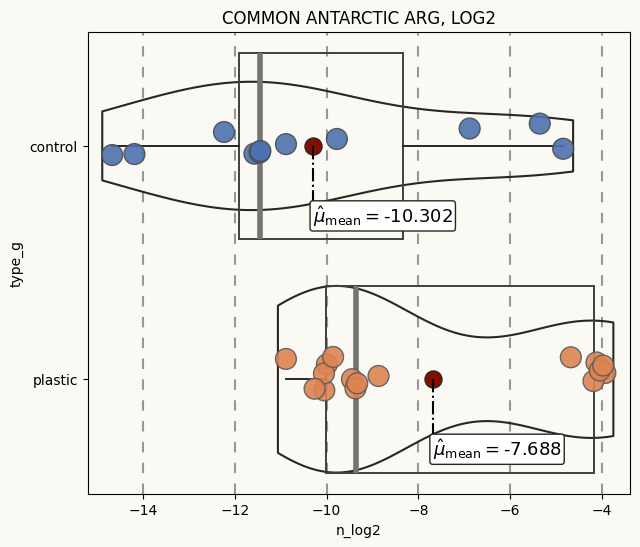

In [11]:
hlines = [5, 0.5, 0.05, 0.005, 0.0005, 0.00005] #sacadas de observar el gráfico-borrador y ver en torno a qué valores van a estar nuestros datos
hlines_log = list(range(-14, -2, 2))

make_chuli_plot_violin(data = summed_arg, 
                       x = "n_log2",
                       y = "type_g",
                       mean_list = means_arg_log, line_list = hlines_log,
                       title = "common antarctic arg, log2",
                       figsize = (7, 6),
                       )
#print(hlines_log)

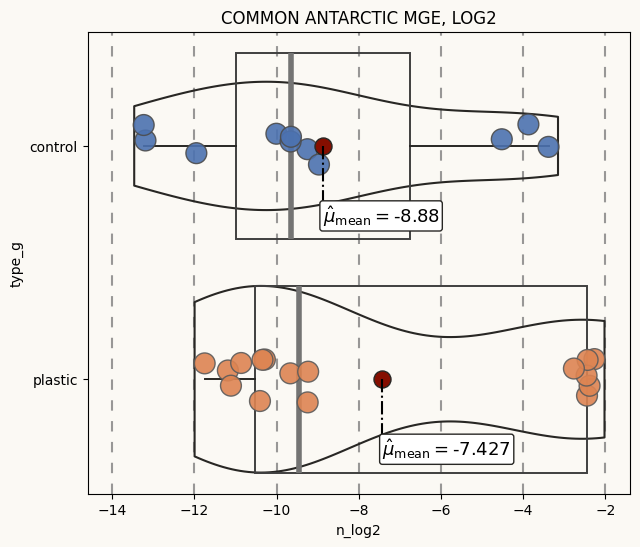

In [12]:
hlines = [5, 0.5, 0.05, 0.005, 0.0005, 0.00005] #sacadas de observar el gráfico-borrador y ver en torno a qué valores van a estar nuestros datos
hlines_log = list(range(-14, 0, 2))

make_chuli_plot_violin(data = summed_mge, 
                       x = "n_log2",
                       y = "type_g",
                       mean_list = means_mge_log, line_list = hlines_log,
                       title = "common antarctic MGE, log2",
                       figsize = (7, 6),
                       )
#print(hlines_log)

## DIFERENCIANDO POR PUNTO DE MUESTREO
Para lidiar con el hecho de que las muestras muestran una clara diferenciación entre Ardley y no Ardley, podemos diferenciar según el punto de muestreo y comparar resultados

In [13]:
var_lst = [group["rel_ab"] for name, group in summed_arg.groupby(["place", "type_g"])] #contains every group
nam_lst = [name for name, group in summed_arg.groupby(["place", "type_g"])] #contains the name of everygroup, SAME ORDER
print("Regular values: ", stats.levene(*var_lst))
var_lst_ln = [group["n_log2"] for name, group in summed_arg.groupby(["place", "type_g"])]
print("Log2: ", stats.levene(*var_lst_ln))

print(stats.kruskal(*var_lst_ln))
post_lolo = sp.posthoc_mannwhitney(var_lst_ln, p_adjust = "fdr_bh")
#post_lolo = sp.posthoc_conover(var_lst_ln, p_adjust = "fdr_bh")

post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                 index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                 inplace = True)
post_lolo = post_lolo[post_lolo < 0.05]
post_lolo

Regular values:  LeveneResult(statistic=6.0983056759807495, pvalue=0.003290705549479123)
Log2:  LeveneResult(statistic=2.1247581128534825, pvalue=0.12474989001163048)
KruskalResult(statistic=21.889285714285705, pvalue=6.878423993426161e-05)


,"(ardley, control)","(ardley, plastic)","(lake, control)","(lake, plastic)"
"(ardley, control)",NaN,0.023810,0.014545,0.010490
"(ardley, plastic)",0.023810,NaN,0.001998,0.001499
"(lake, control)",0.014545,0.001998,NaN,0.004114
"(lake, plastic)",0.010490,0.001499,0.004114,NaN


In [14]:
var_lst = [group["rel_ab"] for name, group in summed_mge.groupby(["place", "type_g"])] #contains every group
nam_lst = [name for name, group in summed_mge.groupby(["place", "type_g"])] #contains the name of everygroup, SAME ORDER
print("Regular values: ", stats.levene(*var_lst))
var_lst_ln = [group["n_log2"] for name, group in summed_mge.groupby(["place", "type_g"])]
print("Log2: ", stats.levene(*var_lst_ln))

print(stats.kruskal(*var_lst_ln))
post_lolo = sp.posthoc_mannwhitney(var_lst_ln, p_adjust = "fdr_bh")
#post_lolo = sp.posthoc_conover(var_lst_ln, p_adjust = "fdr_bh")

post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                 index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                 inplace = True)
post_lolo = post_lolo[post_lolo < 0.05]
post_lolo

Regular values:  LeveneResult(statistic=5.418438504070819, pvalue=0.005727829805307341)
Log2:  LeveneResult(statistic=2.80760170691578, pvalue=0.06219858864223778)
KruskalResult(statistic=18.003571428571433, pvalue=0.00043910428306139643)


,"(ardley, control)","(ardley, plastic)","(lake, control)","(lake, plastic)"
"(ardley, control)",NaN,0.028571,0.018182,0.013986
"(ardley, plastic)",0.028571,NaN,0.001998,0.001499
"(lake, control)",0.018182,0.001998,NaN,NaN
"(lake, plastic)",0.013986,0.001499,NaN,NaN


In [15]:
def make_chuli_plot(data, x, y, mean_list, line_list, title, figsize, orient = "horizontal"):
    # Ya la figura ------------------------------------------
    fig, ax = plt.subplots(figsize = figsize)

    #Color de fondo
    fig.patch.set_facecolor(BG_WHITE)
    ax.set_facecolor(BG_WHITE)

    # Líneas horizontales de escala
    for hline in line_list:
        if orient == "horizontal":
            ax.axvline(hline, color = GREY50, ls = (0, (5, 5)), alpha = 0.8, zorder = 0)
        else:
            ax.axhline(hline, color = GREY50, ls = (0, (5, 5)), alpha = 0.8, zorder = 0)

    # Cajas
    boxes = sns.boxplot(data = data, x = x, y = y,  
                        boxprops = {"zorder": 2, "facecolor": "none", "linewidth": 1.4},
                        whiskerprops = {"color": BLACK, "linewidth": 1.4},
                        medianprops = {"color": GREY_DARK, "solid_capstyle": "butt", "linewidth": 4},
                        showcaps = False
                       )
    #Stripplot
    points = sns.stripplot(data = data, x = x, y = y, 
                           s = 15, alpha = 0.9, linewidth = 1, legend = False, palette = "deep")
    # Add mean value labels ------------------------------------------
    if orient == "horizontal":
        for mean, pos in zip(mean_list[:], ax.get_yticks()):
            # Add dot representing the mean
            ax.scatter(mean, pos, s=150, color=RED_DARK, zorder=3, edgecolors = BLACK)
            # Add line conecting mean value and its label
            ax.plot([mean, mean], [pos, pos + 0.3], ls="dashdot", color="black", zorder=3)
            # Add mean value label.
            ax.text(mean, pos +0.3,
                    r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 3)), fontsize=13, va="center",
                    bbox = {"facecolor":"white","edgecolor":BLACK, "boxstyle":"round", "pad":0.15},
                    zorder = 10
                   )
    else:
        for mean, pos in zip(mean_list[:], ax.get_xticks()):
            ax.scatter(pos, mean, s=150, color=RED_DARK, zorder=3, edgecolors = BLACK)
            ax.plot([pos, pos + 0.3], [mean, mean], ls="dashdot", color="black", zorder=3)
            ax.text(pos + 0.3, mean,
                    r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 3)), fontsize=13, va="center",
                    bbox = {"facecolor":"white","edgecolor": BLACK, "boxstyle":"round", "pad":0.15},
                    zorder = 10
                   )

    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_title(title.upper())
    plt.legend([],[], frameon=False) #ugly hack!

In [16]:
means_arg = [value for name, value in summed_arg.groupby("hacky")["rel_ab"].mean().items()] #esto es el valor de las medias pero lo usaré de posición
means_arg_log = [value for name, value in summed_arg.groupby(["place", "type_g"])["n_log2"].mean().items()]
names = [name for name, value in summed_samples.groupby(["place", "type_g"])["rel_ab"].mean().items()]
means_mge = [value for name, value in summed_mge.groupby("hacky")["rel_ab"].mean().items()]
means_mge_log = [value for name, value in summed_mge.groupby("hacky")["n_log2"].mean().items()]
print(list(zip(means_arg, names)))

[(0.022665778322639066, ('ardley', 'control')), (0.05723799522072895, ('ardley', 'plastic')), (0.0003758709678106161, ('lake', 'control')), (0.001191207761162234, ('lake', 'plastic'))]


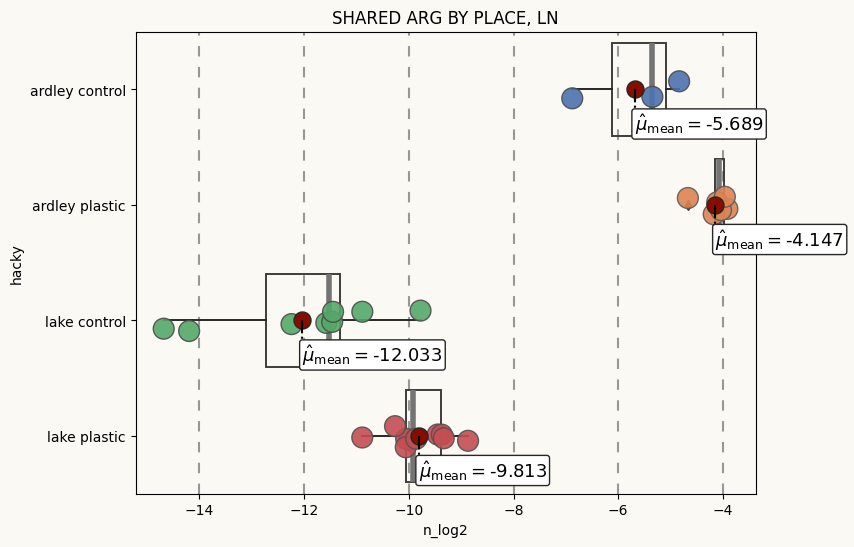

In [17]:
hlines_log = list(range(-14, -2, 2))

make_chuli_plot(data = summed_arg, 
                x = "n_log2", y = "hacky",
                mean_list = means_arg_log, line_list = hlines_log,
                title = "SHARED ARG BY PLACE, ln", figsize = (8, 6), orient = "horizontal"
                )

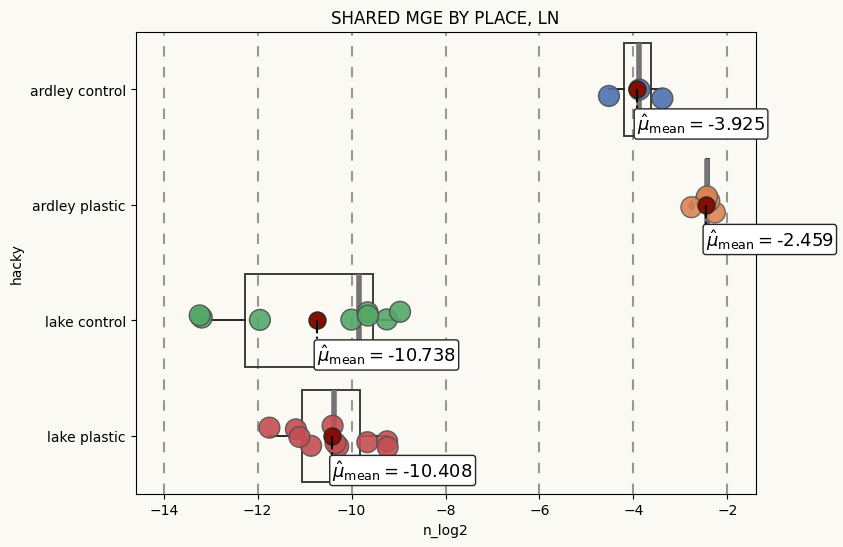

In [18]:
hlines_log = list(range(-14, 0, 2))

make_chuli_plot(data = summed_mge, 
                x = "n_log2", y = "hacky",
                mean_list = means_mge_log, line_list = hlines_log,
                title = "SHARED MGE BY PLACE, ln", figsize = (8, 6), orient = "horizontal"
                )

## DIFERENCIANDO DEL TODO

Parece una tontería, pero es más sencillo obtener estos estadísticos volviendo a correr el código desde el principio que recomponiendo información que ya he borrado

In [19]:
del all_data
del summed_samples
del summed_arg
del summed_mge

In [20]:
all_data = pd.read_csv("../data/resistome_data/clean_data/ab_data_all_fixed.csv", index_col = 0)
all_data.dropna(inplace = True)
all_data = all_data[(all_data["antib"] != "16S")]
all_data = all_data[["Assay", "antib", "sample", "place", "type_f", "type_g", "or_seq", "rel_ab"]] #place viene a ser la estrella del show
all_data = all_data.loc[~all_data["place"].isin([0])]
all_data.loc[all_data["sample"] == 13, "rel_ab"] = all_data.loc[all_data["sample"] == 13]["rel_ab"] / 3
all_data.loc[all_data["sample"] == 14, "rel_ab"] = all_data.loc[all_data["sample"] == 14]["rel_ab"] / 3
all_data = all_data[(all_data.Assay != "aadA7") & (all_data.sample != 5)] #esto también es tremendamente importante
common_amps = all_data[["Assay", "place", "type_g"]].groupby(["place", "Assay"])["type_g"].unique()
common_amps = common_amps.reset_index()
common_amps["type_g"] = common_amps["type_g"].astype("str") #hacky as shit
common_amps = common_amps.loc[(common_amps["type_g"] == "['plastic' 'control']") | (common_amps["type_g"] == "['control' 'plastic']")]

fixed_ardley_data = all_data.loc[all_data["place"] == "ardley"] 
fixed_ardley_data = fixed_ardley_data.loc[fixed_ardley_data["Assay"].isin(list(common_amps.loc[common_amps["place"] == "ardley"]["Assay"].unique()))]
fixed_uru_data = all_data.loc[all_data["place"] == "uru"]
fixed_uru_data = fixed_uru_data.loc[fixed_uru_data["Assay"].isin(list(common_amps.loc[common_amps["place"] == "uru"]["Assay"].unique()))]
fixed_ion_data = all_data.loc[all_data["place"] == "ion"]
fixed_ion_data = fixed_ion_data.loc[fixed_ion_data["Assay"].isin(list(common_amps.loc[common_amps["place"] == "ion"]["Assay"].unique()))]

fixed_all = pd.concat([fixed_ardley_data, fixed_uru_data, fixed_ion_data])
fixed_all.loc[(fixed_all["place"] == "ion") | (fixed_all["place"] == "uru"), "place"] = "lake"

lake_arg_counts = len(fixed_all.loc[(fixed_all["place"] == "lake") & (fixed_all["or_seq"] == "arg")]["Assay"].unique())
ardley_arg_counts = len(fixed_all.loc[(fixed_all["place"] == "ardley") & (fixed_all["or_seq"] == "arg")]["Assay"].unique())
lake_mge_counts = len(fixed_all.loc[(fixed_all["place"] == "lake") & (fixed_all["or_seq"] == "mge")]["Assay"].unique())
ardley_mge_counts = len(fixed_all.loc[(fixed_all["place"] == "ardley") & (fixed_all["or_seq"] == "mge")]["Assay"].unique())

sp_grouped = fixed_all.groupby(["sample", "or_seq", "place", "type_f"]) #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples = sp_grouped["rel_ab"].sum() # y calcula la suma del nº de copias de todos los integrantes
summed_samples = summed_samples.reset_index() #aquí paso a df para facilitar el resto de pasos

#He aquí lo nuevo
summed_samples.loc[(summed_samples["place"] == "lake") & (summed_samples["or_seq"] == "arg"), "rel_ab"] = summed_samples.loc[(summed_samples["place"] == "lake") & (summed_samples["or_seq"] == "arg")]["rel_ab"] / lake_arg_counts
summed_samples.loc[(summed_samples["place"] == "ardley") & (summed_samples["or_seq"] == "arg"), "rel_ab"] = summed_samples.loc[(summed_samples["place"] == "ardley") & (summed_samples["or_seq"] == "arg")]["rel_ab"] / ardley_arg_counts
summed_samples.loc[(summed_samples["place"] == "lake") & (summed_samples["or_seq"] == "mge"), "rel_ab"] = summed_samples.loc[(summed_samples["place"] == "lake") & (summed_samples["or_seq"] == "mge")]["rel_ab"] / lake_mge_counts
summed_samples.loc[(summed_samples["place"] == "ardley") & (summed_samples["or_seq"] == "mge"), "rel_ab"] = summed_samples.loc[(summed_samples["place"] == "ardley") & (summed_samples["or_seq"] == "mge")]["rel_ab"] / ardley_mge_counts

summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])

summed_samples["hacky"] = summed_samples["place"] + " " + summed_samples["type_f"]
summed_samples.sort_values(by = "hacky", inplace = True)

summed_arg = summed_samples[(summed_samples.or_seq == "arg")]
summed_mge = summed_samples[(summed_samples.or_seq == "mge")]
summed_mge.head()

,sample,or_seq,place,type_f,rel_ab,n_log2,hacky
47,24.0,mge,ardley,EPS,0.182071,-2.457426,ardley EPS
45,23.0,mge,ardley,EPS,0.191533,-2.384337,ardley EPS
43,22.0,mge,ardley,EPS,0.207896,-2.266068,ardley EPS
53,27.0,mge,ardley,PUR,0.183446,-2.446569,ardley PUR
51,26.0,mge,ardley,PUR,0.147078,-2.765350,ardley PUR


In [21]:
var_lst = [group["rel_ab"] for name, group in summed_arg.groupby(["or_seq", "place", "type_f"])] #contains every group
nam_lst = [name for name, group in summed_arg.groupby(["or_seq", "place", "type_f"])] #contains the name of everygroup, SAME ORDER
print("Regular values: ", stats.levene(*var_lst))
var_lst_ln = [group["n_log2"] for name, group in summed_arg.groupby(["or_seq", "place", "type_f"])]
print("Log2: ", stats.levene(*var_lst_ln))

print(stats.kruskal(*var_lst_ln))
post_lolo = sp.posthoc_conover(var_lst_ln, p_adjust = "fdr_bh")
#post_lolo = sp.posthoc_mannwhitney(var_lst_ln, p_adjust = "fdr_bh")
post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                 index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                 inplace = True)

# Y ahora ver solo lo interesante
post_lolo = post_lolo[post_lolo < 0.05]
post_lolo

Regular values:  LeveneResult(statistic=2.499067953033111, pvalue=0.057192813678936374)
Log2:  LeveneResult(statistic=3.1380184427217603, pvalue=0.024692814426787085)
KruskalResult(statistic=23.411375661375644, pvalue=0.0006697807434995623)


,"(arg, ardley, EPS)","(arg, ardley, PUR)","(arg, ardley, soil)","(arg, lake, EPS)","(arg, lake, PUR)","(arg, lake, soil)","(arg, lake, water)"
"(arg, ardley, EPS)",NaN,NaN,4.100920e-02,0.000083,0.000005,3.055326e-08,8.465617e-07
"(arg, ardley, PUR)",NaN,NaN,NaN,0.000437,0.000020,5.481298e-08,3.134086e-06
"(arg, ardley, soil)",4.100920e-02,NaN,NaN,0.018673,0.000680,7.790676e-07,6.624138e-05
"(arg, lake, EPS)",8.280934e-05,4.366424e-04,1.867276e-02,NaN,NaN,1.367546e-05,6.583862e-03
"(arg, lake, PUR)",4.782835e-06,1.995277e-05,6.796997e-04,NaN,NaN,3.789589e-04,NaN
"(arg, lake, soil)",3.055326e-08,5.481298e-08,7.790676e-07,0.000014,0.000379,NaN,1.392703e-02
"(arg, lake, water)",8.465617e-07,3.134086e-06,6.624138e-05,0.006584,NaN,1.392703e-02,NaN


In [22]:
var_lst = [group["rel_ab"] for name, group in summed_mge.groupby(["or_seq", "place", "type_f"])] #contains every group
nam_lst = [name for name, group in summed_mge.groupby(["or_seq", "place", "type_f"])] #contains the name of everygroup, SAME ORDER
print("Regular values: ", stats.levene(*var_lst))
var_lst_ln = [group["n_log2"] for name, group in summed_mge.groupby(["or_seq", "place", "type_f"])]
print("Log2: ", stats.levene(*var_lst_ln))

print(stats.kruskal(*var_lst_ln))
post_lolo = sp.posthoc_conover(var_lst_ln, p_adjust = "fdr_bh")
#post_lolo = sp.posthoc_mannwhitney(var_lst_ln, p_adjust = "fdr_bh")
post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                 index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                 inplace = True)

# Y ahora ver solo lo interesante
post_lolo = post_lolo[post_lolo < 0.05]
post_lolo

Regular values:  LeveneResult(statistic=2.4466957746627394, pvalue=0.061393618706384614)
Log2:  LeveneResult(statistic=1.505208677890235, pvalue=0.22715155270045034)
KruskalResult(statistic=18.82724867724866, pvalue=0.004465552070990085)


,"(mge, ardley, EPS)","(mge, ardley, PUR)","(mge, ardley, soil)","(mge, lake, EPS)","(mge, lake, PUR)","(mge, lake, soil)","(mge, lake, water)"
"(mge, ardley, EPS)",NaN,NaN,NaN,0.001035,0.001910,0.001035,0.003835
"(mge, ardley, PUR)",NaN,NaN,NaN,0.001485,0.004187,0.001504,0.006675
"(mge, ardley, soil)",NaN,NaN,NaN,0.006541,0.029318,0.006675,NaN
"(mge, lake, EPS)",0.001035,0.001485,0.006541,NaN,NaN,NaN,NaN
"(mge, lake, PUR)",0.001910,0.004187,0.029318,NaN,NaN,NaN,NaN
"(mge, lake, soil)",0.001035,0.001504,0.006675,NaN,NaN,NaN,NaN
"(mge, lake, water)",0.003835,0.006675,NaN,NaN,NaN,NaN,NaN


In [23]:
means_arg = [value for name, value in summed_arg.groupby("hacky")["rel_ab"].mean().items()] #esto es el valor de las medias pero lo usaré de posición
means_arg_log = [value for name, value in summed_arg.groupby("hacky")["n_log2"].mean().items()]
names = [name for name, value in summed_samples.groupby("hacky")["rel_ab"].mean().items()]
means_mge = [value for name, value in summed_mge.groupby("hacky")["rel_ab"].mean().items()]
means_mge_log = [value for name, value in summed_mge.groupby("hacky")["n_log2"].mean().items()]
print(list(zip(means_arg, names)))

[(0.06182224511868439, 'ardley EPS'), (0.05265374532277351, 'ardley PUR'), (0.022665778322639066, 'ardley soil'), (0.0014009117622712666, 'lake EPS'), (0.0009815037600532015, 'lake PUR'), (0.00015651738001605596, 'lake soil'), (0.0005952245556051762, 'lake water')]


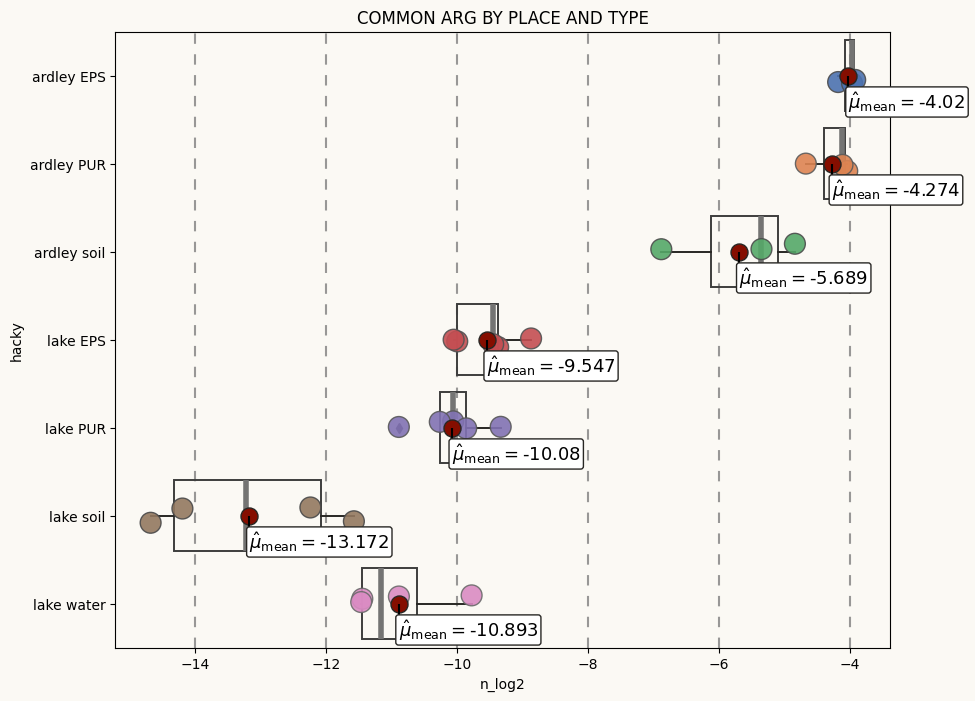

In [24]:
hlines_log = list(range(-14, -2, 2))

make_chuli_plot(data = summed_arg, 
                x = "n_log2", y = "hacky",
                mean_list = means_arg_log, line_list = hlines_log,
                title = "COMMON ARG BY PLACE AND TYPE", figsize = (10, 8), orient = "horizontal"
                )

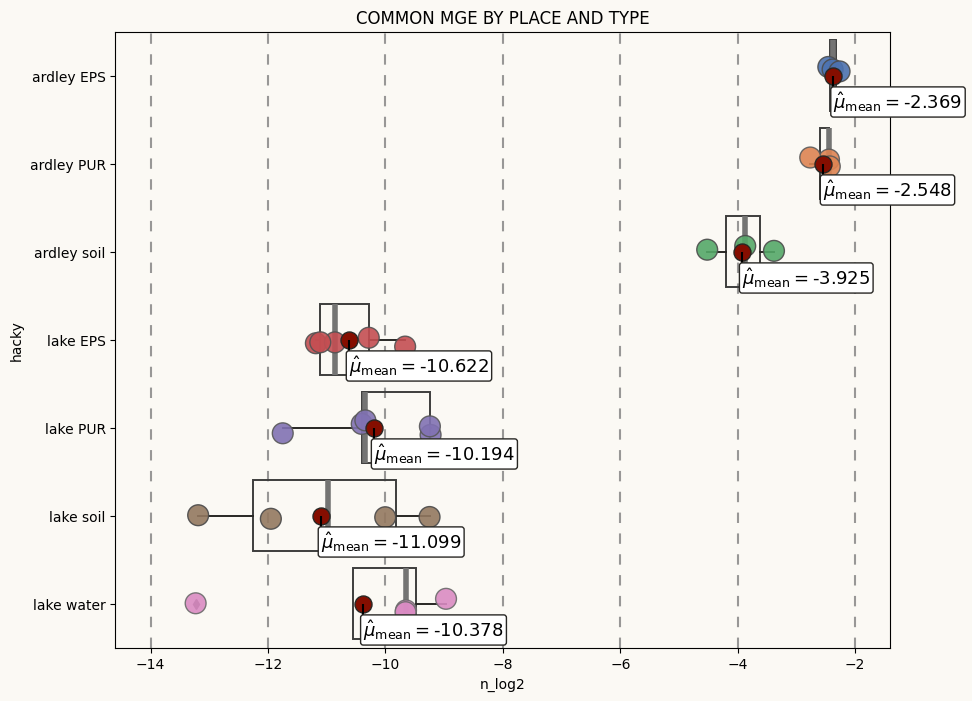

In [25]:
hlines_log = list(range(-14, 0, 2))

make_chuli_plot(data = summed_mge, 
                x = "n_log2", y = "hacky",
                mean_list = means_mge_log, line_list = hlines_log,
                title = "COMMON MGE BY PLACE AND TYPE", figsize = (10, 8), orient = "horizontal"
                )

Como se puede observar, sale que no hay diferencias entre grupos en los que sería de esperar que las hubiera. Por ello, voy a hacer algo que CREO que es p-hacking y voy a separar POR COMPLETO las muestras sitio a sitio

In [26]:
### SÓLO ARDLEY
var_lst = [group["rel_ab"] for name, group in summed_arg.loc[summed_arg["place"] == "ardley"].groupby(["or_seq", "type_f"])] #contains every group
nam_lst = [name for name, group in summed_arg.loc[summed_arg["place"] == "ardley"].groupby(["or_seq", "type_f"])] #contains the name of everygroup, SAME ORDER
print("Regular values: ", stats.levene(*var_lst))
var_lst_ln = [group["n_log2"] for name, group in summed_arg.loc[summed_arg["place"] == "ardley"].groupby(["or_seq", "type_f"])]
print("Log2: ", stats.levene(*var_lst_ln))

print(stats.kruskal(*var_lst_ln))
post_lolo = sp.posthoc_conover(var_lst_ln, p_adjust = "fdr_bh")
#post_lolo = sp.posthoc_mannwhitney(var_lst_ln, p_adjust = "fdr_bh")
post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                 index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                 inplace = True)

# Y ahora ver solo lo interesante
post_lolo = post_lolo[post_lolo < 0.05]
post_lolo

Regular values:  LeveneResult(statistic=0.3379035106941741, pvalue=0.72600971007159)
Log2:  LeveneResult(statistic=1.239063420420791, pvalue=0.3544492175116259)
KruskalResult(statistic=5.955555555555556, pvalue=0.05090583233639852)


,"(arg, EPS)","(arg, PUR)","(arg, soil)"
"(arg, EPS)",NaN,NaN,0.019374
"(arg, PUR)",NaN,NaN,0.046186
"(arg, soil)",0.019374,0.046186,NaN


In [27]:
var_lst = [group["rel_ab"] for name, group in summed_mge.loc[summed_mge["place"] == "ardley"].groupby(["or_seq", "type_f"])] #contains every group
nam_lst = [name for name, group in summed_mge.loc[summed_mge["place"] == "ardley"].groupby(["or_seq", "type_f"])] #contains the name of everygroup, SAME ORDER
print("Regular values: ", stats.levene(*var_lst))
var_lst_ln = [group["n_log2"] for name, group in summed_mge.loc[summed_mge["place"] == "ardley"].groupby(["or_seq", "type_f"])]
print("Log2: ", stats.levene(*var_lst_ln))

print(stats.kruskal(*var_lst_ln))
post_lolo = sp.posthoc_conover(var_lst_ln, p_adjust = "fdr_bh")
#post_lolo = sp.posthoc_mannwhitney(var_lst_ln, p_adjust = "fdr_bh")
post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                 index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                 inplace = True)

# Y ahora ver solo lo interesante
post_lolo = post_lolo[post_lolo < 0.05]
post_lolo

Regular values:  LeveneResult(statistic=0.24419633536555813, pvalue=0.7907557817385473)
Log2:  LeveneResult(statistic=1.7349589603813325, pvalue=0.25434025750990674)
KruskalResult(statistic=5.955555555555556, pvalue=0.05090583233639852)


,"(mge, EPS)","(mge, PUR)","(mge, soil)"
"(mge, EPS)",NaN,NaN,0.019374
"(mge, PUR)",NaN,NaN,0.046186
"(mge, soil)",0.019374,0.046186,NaN


In [28]:
means_arg_ardley = [value for name, value in summed_arg.loc[summed_arg["place"] == "ardley"].groupby("hacky")["rel_ab"].mean().items()] #esto es el valor de las medias pero lo usaré de posición
means_arg_log_ardley = [value for name, value in summed_arg.loc[summed_arg["place"] == "ardley"].groupby("hacky")["n_log2"].mean().items()]
names_ardley = [name for name, value in summed_samples.loc[summed_samples["place"] == "ardley"].groupby("hacky")["rel_ab"].mean().items()]
means_mge_ardley = [value for name, value in summed_mge.loc[summed_mge["place"] == "ardley"].groupby("hacky")["rel_ab"].mean().items()]
means_mge_log_ardley = [value for name, value in summed_mge.loc[summed_mge["place"] == "ardley"].groupby("hacky")["n_log2"].mean().items()]

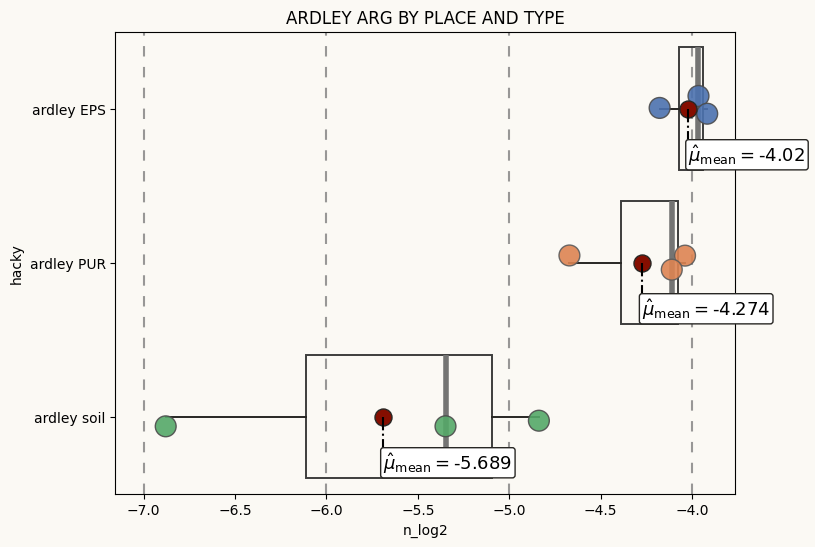

In [29]:
hlines_log = list(range(-7, -3, 1))

make_chuli_plot(data = summed_arg.loc[summed_arg["place"] == "ardley"], 
                x = "n_log2", y = "hacky",
                mean_list = means_arg_log_ardley, line_list = hlines_log,
                title = "ARDLEY ARG BY PLACE AND TYPE", figsize = (8, 6), orient = "horizontal"
                )

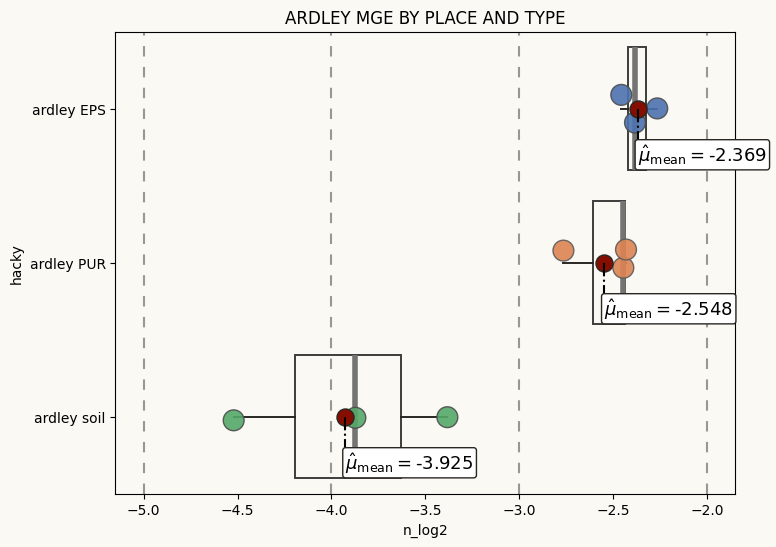

In [30]:
hlines_log = list(range(-5, -1, 1))

make_chuli_plot(data = summed_mge.loc[summed_mge["place"] == "ardley"], 
                x = "n_log2", y = "hacky",
                mean_list = means_mge_log_ardley, line_list = hlines_log,
                title = "ARDLEY MGE BY PLACE AND TYPE", figsize = (8, 6), orient = "horizontal"
                )

In [31]:
### SÓLO LAGOS
var_lst = [group["rel_ab"] for name, group in summed_arg.loc[summed_arg["place"] == "lake"].groupby(["or_seq", "type_f"])] #contains every group
nam_lst = [name for name, group in summed_arg.loc[summed_arg["place"] == "lake"].groupby(["or_seq", "type_f"])] #contains the name of everygroup, SAME ORDER
print("Regular values: ", stats.levene(*var_lst))
var_lst_ln = [group["n_log2"] for name, group in summed_arg.loc[summed_arg["place"] == "lake"].groupby(["or_seq", "type_f"])]
print("Log2: ", stats.levene(*var_lst_ln))

print(stats.kruskal(*var_lst_ln))
post_lolo = sp.posthoc_conover(var_lst_ln, p_adjust = "fdr_bh")
#post_lolo = sp.posthoc_mannwhitney(var_lst_ln, p_adjust = "fdr_bh")
post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                 index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                 inplace = True)

# Y ahora ver solo lo interesante
post_lolo = post_lolo[post_lolo < 0.05]
post_lolo

Regular values:  LeveneResult(statistic=0.6458555234946184, pvalue=0.5983335967911242)
Log2:  LeveneResult(statistic=4.938184721102827, pvalue=0.015211375020636398)
KruskalResult(statistic=11.815789473684205, pvalue=0.008041579198797711)


,"(arg, EPS)","(arg, PUR)","(arg, soil)","(arg, water)"
"(arg, EPS)",NaN,NaN,0.000504,0.027154
"(arg, PUR)",NaN,NaN,0.004009,NaN
"(arg, soil)",0.000504,0.004009,NaN,0.037970
"(arg, water)",0.027154,NaN,0.037970,NaN


In [32]:
### SÓLO LAGOS
var_lst = [group["rel_ab"] for name, group in summed_mge.loc[summed_mge["place"] == "lake"].groupby(["or_seq", "type_f"])] #contains every group
nam_lst = [name for name, group in summed_mge.loc[summed_mge["place"] == "lake"].groupby(["or_seq", "type_f"])] #contains the name of everygroup, SAME ORDER
print("Regular values: ", stats.levene(*var_lst))
var_lst_ln = [group["n_log2"] for name, group in summed_mge.loc[summed_mge["place"] == "lake"].groupby(["or_seq", "type_f"])]
print("Log2: ", stats.levene(*var_lst_ln))

print(stats.kruskal(*var_lst_ln))
post_lolo = sp.posthoc_conover(var_lst_ln, p_adjust = "fdr_bh")
#post_lolo = sp.posthoc_mannwhitney(var_lst_ln, p_adjust = "fdr_bh")
post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                 index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                 inplace = True)

# Y ahora ver solo lo interesante
post_lolo = post_lolo[post_lolo < 0.05]
post_lolo

Regular values:  LeveneResult(statistic=0.5650373553041703, pvalue=0.6469730331707759)
Log2:  LeveneResult(statistic=0.9374162167918437, pvalue=0.4487550297858093)
KruskalResult(statistic=1.6824561403508724, pvalue=0.6408412152377583)


,"(mge, EPS)","(mge, PUR)","(mge, soil)","(mge, water)"
"(mge, EPS)",NaN,NaN,NaN,NaN
"(mge, PUR)",NaN,NaN,NaN,NaN
"(mge, soil)",NaN,NaN,NaN,NaN
"(mge, water)",NaN,NaN,NaN,NaN


In [33]:
means_arg_lake = [value for name, value in summed_arg.loc[summed_arg["place"] == "lake"].groupby("hacky")["rel_ab"].mean().items()] #esto es el valor de las medias pero lo usaré de posición
means_arg_log_lake = [value for name, value in summed_arg.loc[summed_arg["place"] == "lake"].groupby("hacky")["n_log2"].mean().items()]
names_lake = [name for name, value in summed_samples.loc[summed_samples["place"] == "lake"].groupby("hacky")["rel_ab"].mean().items()]
means_mge_lake = [value for name, value in summed_mge.loc[summed_mge["place"] == "lake"].groupby("hacky")["rel_ab"].mean().items()]
means_mge_log_lake = [value for name, value in summed_mge.loc[summed_mge["place"] == "lake"].groupby("hacky")["n_log2"].mean().items()]

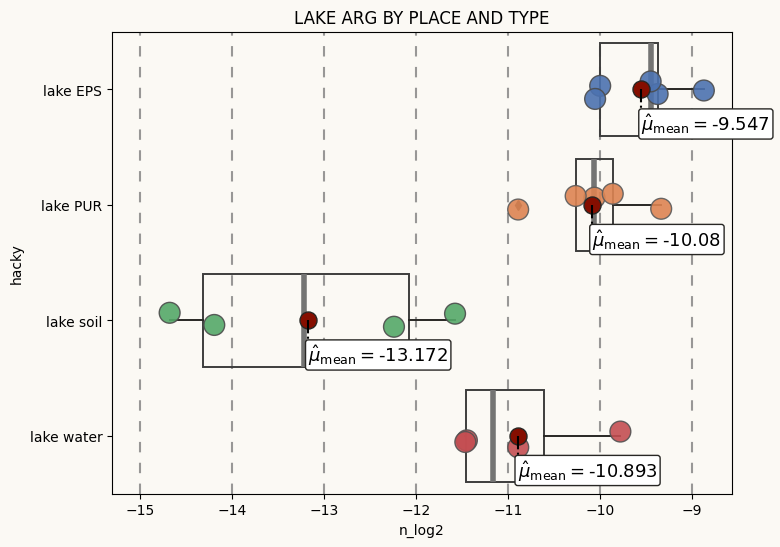

In [34]:
hlines_log = list(range(-15, -8, 1))

make_chuli_plot(data = summed_arg.loc[summed_arg["place"] == "lake"], 
                x = "n_log2", y = "hacky",
                mean_list = means_arg_log_lake, line_list = hlines_log,
                title = "LAKE ARG BY PLACE AND TYPE", figsize = (8, 6), orient = "horizontal"
                )

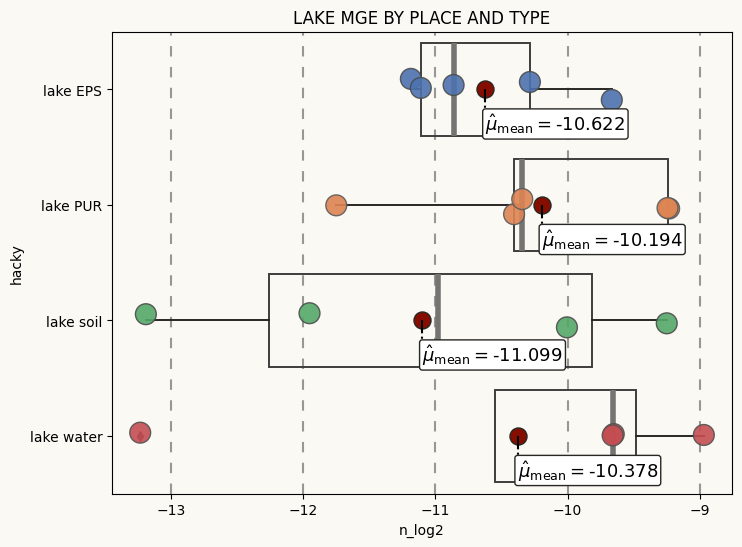

In [37]:
hlines_log = list(range(-13, -8, 1))

make_chuli_plot(data = summed_mge.loc[summed_mge["place"] == "lake"], 
                x = "n_log2", y = "hacky",
                mean_list = means_mge_log_lake, line_list = hlines_log,
                title = "LAKE MGE BY PLACE AND TYPE", figsize = (8, 6), orient = "horizontal"
                )